# IBM AI Workflow Capstone Part 1 - Data wrangling

This is Part 1 of the Capstone Project from [IBM AI Enterprise Workflow specialization](https://www.coursera.org/specializations/ibm-ai-workflow) where we investigate the data and perform basic EDA to find some insights on the surface.

In [3]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

from application.utils.ingestion import fetch_data
from application.utils.processing import convert_to_ts
from application.utils.plot import ts_plot

In [4]:
#  Get data directory and fetch them
df = fetch_data(os.path.join("data","cs-train"))
df

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28
...,...,...,...,...,...,...,...,...,...,...
815006,United Kingdom,16098.0,31,562271,7,3.75,22725,2,2019,2019-07-31
815007,United Kingdom,16098.0,31,562271,7,3.75,22726,12,2019,2019-07-31
815008,United Kingdom,16098.0,31,562271,7,3.75,22727,6,2019,2019-07-31
815009,United Kingdom,14056.0,31,562269,7,2.95,22090,2,2019,2019-07-31


Some information of the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815011 entries, 0 to 815010
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   day           815011 non-null  int64         
 3   invoice       815011 non-null  object        
 4   month         815011 non-null  int64         
 5   price         815011 non-null  float64       
 6   stream_id     815011 non-null  object        
 7   times_viewed  815011 non-null  int64         
 8   year          815011 non-null  int64         
 9   invoice_date  815011 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 62.2+ MB


There are fewer Non-Null entries in `customer_id` than other columns, let's investigate!

## Null values

### customer_id

We find all the columns with missing values, a.k.a. columns with positive number of null values.

In [6]:
## missing values
print(df.isnull().sum())

country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64


In [7]:
# Proportion of null values
df.customer_id.isnull().sum()/len(df)

0.2328336672756564

The `customer_id` column is $23.3\%$ empty. Let's break it down into seperate years to see in details.

In [8]:
df_total_year = df[['year', 'country']].groupby(['year']).count()["country"]

df_missing_year = df[df.customer_id.isnull()][['year', 'country']].groupby(['year']).count()["country"]

df_missing_proportion = pd.DataFrame(data={
    "total": df_total_year,
    "missing": df_missing_year,
    "percentage": df_missing_year / df_total_year
})
df_missing_proportion

,total,missing,percentage
year,,,
2017,45228,13468,0.297780
2018,522714,110090,0.210612
2019,247069,66204,0.267958


Plot a little bar chart demonstrating the difference between years, which overall is not drastic from each other.

Text(0.5, 1.0, 'Percentage of missing values per year.')

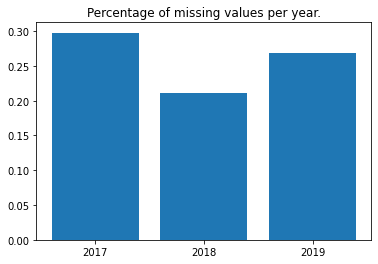

In [9]:
plt.bar( ['2017', '2018', '2019'], df_missing_proportion["percentage"])
plt.title("Percentage of missing values per year.")

### Dates

In [10]:
print("Number of unique dates", df.invoice_date.nunique())
print(f"Range of dates: {(df.invoice_date.max() -  df.invoice_date.min()).days + 1}, max: {df.invoice_date.max()}, min: {df.invoice_date.min()}")

Number of unique dates 495
Range of dates: 611, max: 2019-07-31 00:00:00, min: 2017-11-28 00:00:00


Here we can answer the question in the Quiz (600).

## Summary Statistics

Now we take a look at how each variable's distribution is, seeing if skewness appears in our dataset.

In [11]:
df.describe()

,customer_id,day,month,price,times_viewed,year
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,15.064819,6.592718,4.802631,5.231106,2018.247654
std,1698.360788,8.788845,3.598781,135.058707,5.109982,0.545261
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13956.000000,7.000000,3.000000,1.250000,1.000000,2018.000000
50%,15279.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16813.000000,23.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


Price has the highest variance, and it seems like it has negative values. Why is that?

## Revenue

We now analyze the revenue, our main prediction goal. From the plots below, we see that most of the revenue is coming from countries in Europe, such as the UK, EIRE, Germany and France. It is also noteworthy that the revenue in the period from the first ranked country (the United Kingdom) alone is almost 90% of the total revenue, being 32x the revenue brought by the second ranked country (EIRE).

Below, you'll find bar plots for revenue grouped by country in the period, both in the original scale and in log scale.

In [12]:
df_revenue_country = df[['country', 'price']].groupby('country').sum()
df_revenue_country.columns = ['revenue']
df_revenue_country.sort_values(by='revenue', inplace=True, ascending=False)

In [13]:
df_revenue_country[df_revenue_country.index=="United Kingdom"].revenue/df_revenue_country.revenue.sum()

country
United Kingdom    0.899677
Name: revenue, dtype: float64

In [14]:
df_revenue_country['revenue'].values[0] / df_revenue_country['revenue'].values[1]

32.890067135080194

<BarContainer object of 43 artists>

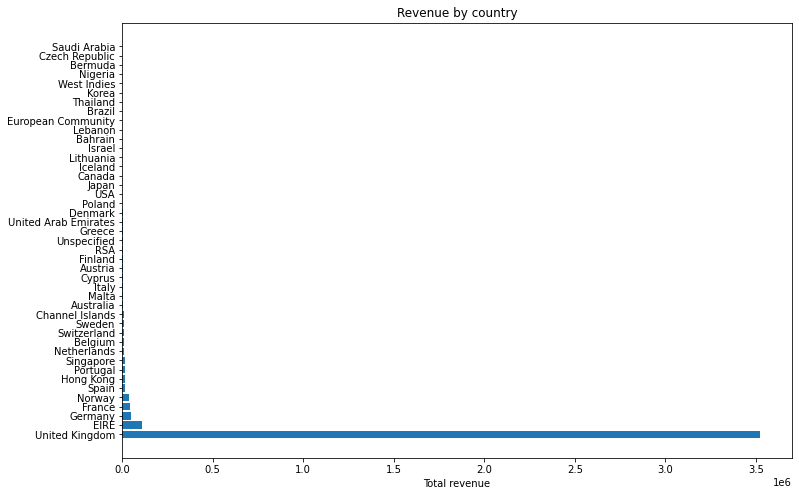

In [15]:
plt.figure(figsize=(12,8))
plt.title("Revenue by country")
plt.xlabel("Total revenue")
plt.barh(df_revenue_country.index, df_revenue_country.revenue)

<BarContainer object of 43 artists>

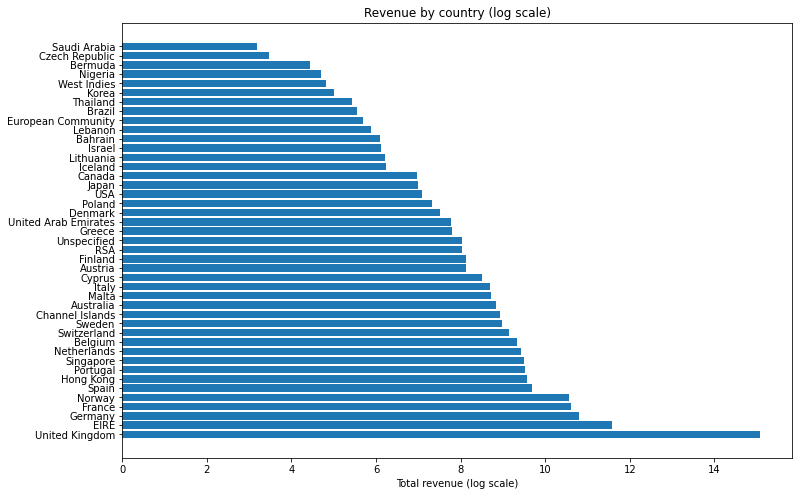

In [16]:
plt.figure(figsize=(12,8))
plt.title("Revenue by country (log scale)")
plt.xlabel("Total revenue (log scale)")
plt.barh(df_revenue_country.index, np.log(df_revenue_country.revenue))

### Time series

Using the built-in `convert_to_ts()` function to convert our standard DataFrame to a Time-series DataFrame.

In [17]:
df_ts = convert_to_ts(df)
df_ts

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-28,3223,166,1345,15047,2017-11,14450.54
1,2017-11-29,3277,133,1397,14159,2017-11,13411.96
2,2017-11-30,3002,150,1335,15766,2017-11,13290.25
3,2017-12-01,2559,107,1256,12524,2017-12,9687.28
4,2017-12-02,402,32,287,3313,2017-12,1443.26
...,...,...,...,...,...,...,...
606,2019-07-27,0,0,0,0,2019-07,0.00
607,2019-07-28,1271,43,789,7004,2019-07,3150.26
608,2019-07-29,1200,51,770,7025,2019-07,4374.54
609,2019-07-30,1369,61,862,8492,2019-07,16374.76


Plot the time series using the `ts_plot()` function, and we loop through all features

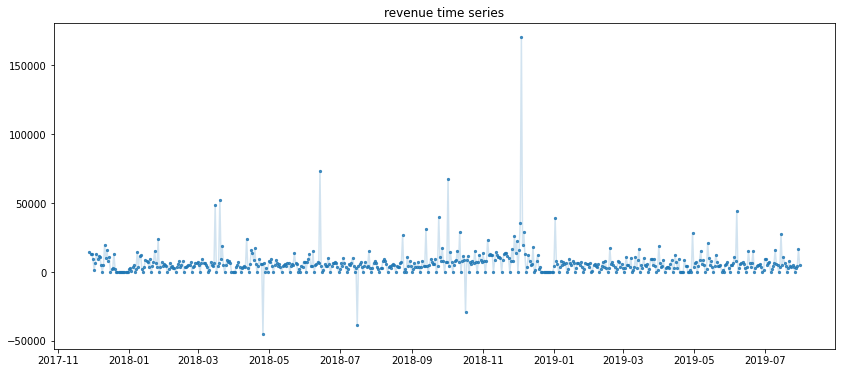

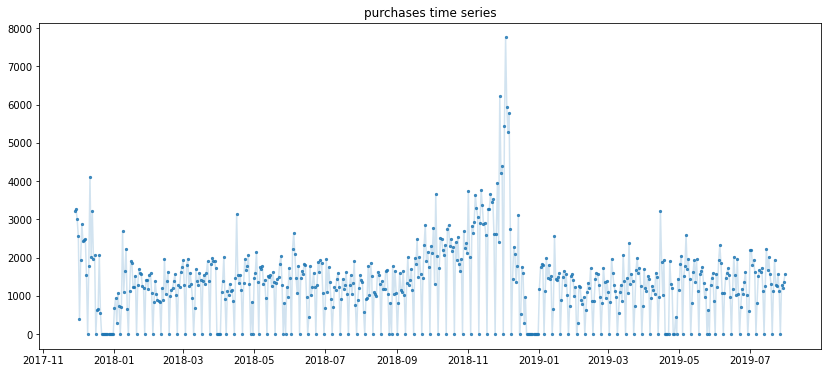

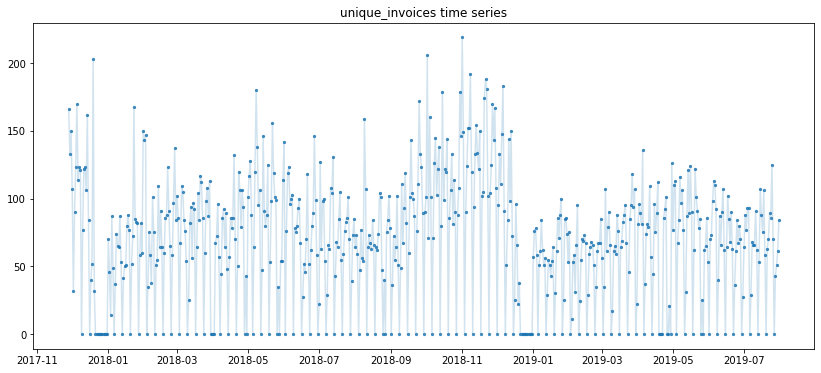

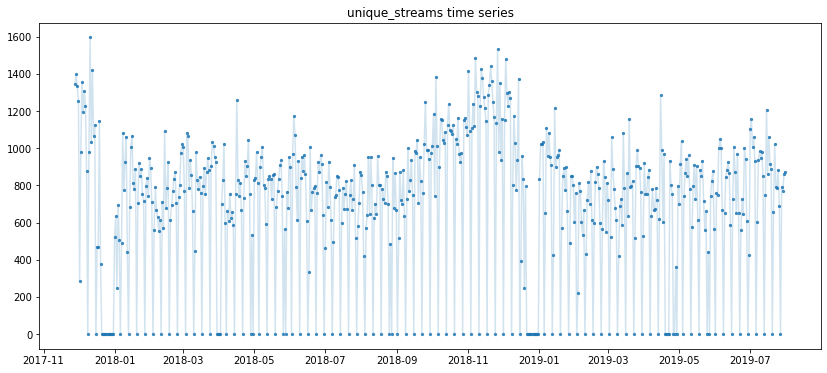

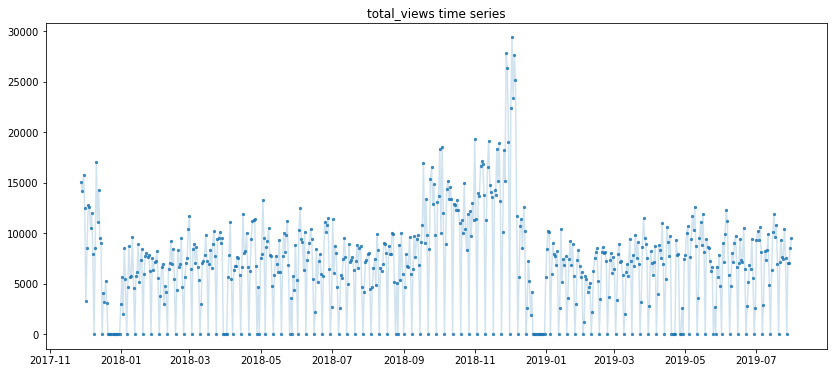

In [19]:
for col in ['revenue','purchases', 'unique_invoices', 'unique_streams', 'total_views']:
    ts_plot(df_ts.date,df_ts[col],figx=14,figy=6, title=f"{col} time series")